# Global Air Pollution Analysis and City Clustering Using Machine Learning

**Project goal:** Build an improved, end-to-end notebook that merges global air pollution data with city coordinates, performs cleaning, EDA, geospatial visualizations, multiple clustering algorithms, PCA, cluster profiling, and produces actionable insights.



In [3]:
# 1. Imports and load datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import folium
import json
from pathlib import Path

# Load data files
pollution_path = 'global air pollution dataset.csv'
cities_path = 'worldcities.csv'

pollution = pd.read_csv(pollution_path)
cities = pd.read_csv(cities_path)

print('pollution shape:', pollution.shape)
print('cities shape:', cities.shape)

pollution shape: (23463, 12)
cities shape: (48059, 11)


In [4]:
# Show head of pollution data
pollution.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good


## 2. Data cleaning & preprocessing
- Normalize column names
- Convert AQI categories to numeric
- Merge city coordinates from `worldcities.csv` using City + Country
- Create a combined AQI severity score

In [5]:
# Normalize column names
pollution.columns = [c.strip() for c in pollution.columns]
pollution.rename(columns=lambda x: x.strip(), inplace=True)

# Standardize city and country strings for merging
pollution['City_clean'] = pollution['City'].str.lower().str.replace('\\s+', ' ', regex=True).str.strip()
pollution['Country_clean'] = pollution['Country'].str.lower().str.replace('\\s+', ' ', regex=True).str.strip()

cities['city_clean'] = cities['city'].str.lower().str.replace('\\s+', ' ', regex=True).str.strip()
cities['country_clean'] = cities['country'].str.lower().str.replace('\\s+', ' ', regex=True).str.strip()

# Try merge on city+country
merged = pollution.merge(cities[['city_clean','country_clean','lat','lng','population']],
                         left_on=['City_clean','Country_clean'],
                         right_on=['city_clean','country_clean'],
                         how='left')

print('Merged shape:', merged.shape)
missing_coords = merged['lat'].isna().sum()
print('Rows missing coords after merge:', missing_coords)

# Show rows that missed merge (sample)
merged[merged['lat'].isna()][['Country','City']].drop_duplicates().head(10)

Merged shape: (23836, 19)
Rows missing coords after merge: 13449


,Country,City
0,Russian Federation,Praskoveya
4,France,Punaauia
5,United States of America,Punta Gorda
6,Germany,Puttlingen
8,Russian Federation,Pyatigorsk
9,Egypt,Qalyub
12,India,Radaur
13,Pakistan,Radhan
14,Republic of North Macedonia,Radovis
16,India,Rajgir


### 2.1 Handle missing coordinates
If some cities did not merge (naming mismatch), the notebook shows examples. You can manually fix mappings or use fuzzy matching (optional). For now we will proceed and fill missing coordinates with country-level median lat/lng where possible.

In [6]:
# Fill missing coordinates with country medians
country_coords = cities.groupby('country_clean')[['lat','lng']].median().reset_index()
merged = merged.merge(country_coords, left_on='Country_clean', right_on='country_clean', how='left', suffixes=('','_countrymedian'))

merged['lat_final'] = merged['lat'].fillna(merged['lat_countrymedian'])
merged['lng_final'] = merged['lng'].fillna(merged['lng_countrymedian'])

# If still missing, leave NaN
merged[['Country','City','lat_final','lng_final']].head()

,Country,City,lat_final,lng_final
0,Russian Federation,Praskoveya,NaN,NaN
1,Brazil,Presidente Dutra,-5.2900,-44.4900
2,Italy,Priolo Gargallo,37.1667,15.1833
3,Poland,Przasnysz,53.0167,20.8833
4,France,Punaauia,48.0101,2.4833


### 2.2 Convert AQI categories to numeric and create AQI score
We convert textual AQI categories to ordinal integers and create a combined AQI severity score using weighted pollutants (weights are configurable).

In [7]:
# Map AQI categories to numeric (example mapping)
cat_map = {'Good':1, 'Moderate':2, 'Unhealthy':3, 'Very Unhealthy':4, 'Hazardous':5}
for col in ['AQI Category','CO AQI Category','Ozone AQI Category','NO2 AQI Category','PM2.5 AQI Category']:
    if col in merged.columns:
        merged[col+'_num'] = merged[col].map(cat_map).astype('Float64')

# Ensure pollutant numeric values exist
pollutant_cols = ['CO AQI Value','Ozone AQI Value','NO2 AQI Value','PM2.5 AQI Value','AQI Value']
available_pollutants = [c for c in pollutant_cols if c in merged.columns]
available_pollutants

['CO AQI Value',
 'Ozone AQI Value',
 'NO2 AQI Value',
 'PM2.5 AQI Value',
 'AQI Value']

In [8]:
# Create combined AQI_Score using weights (tweakable)
weights = {'PM2.5 AQI Value':0.4, 'Ozone AQI Value':0.2, 'NO2 AQI Value':0.2, 'CO AQI Value':0.2}
# Use only available columns
w_sum = sum(weights[c] for c in weights if c in merged.columns)
merged['AQI_Score'] = 0.0
for col, w in weights.items():
    if col in merged.columns:
        merged['AQI_Score'] += merged[col].fillna(0) * w
# Normalize by sum of used weights to keep scale aligned
if w_sum>0:
    merged['AQI_Score'] = merged['AQI_Score'] / w_sum

merged[['Country','City','AQI Value','AQI_Score']].head()

,Country,City,AQI Value,AQI_Score
0,Russian Federation,Praskoveya,51,27.8
1,Brazil,Presidente Dutra,41,17.8
2,Italy,Priolo Gargallo,66,34.8
3,Poland,Przasnysz,34,15.0
4,France,Punaauia,22,6.8


## 3. Exploratory Data Analysis (EDA)
- Basic distributions
- Correlations
- Top polluted cities and countries

In [9]:
# Top 10 cities by AQI_Score
top10 = merged.sort_values('AQI_Score', ascending=False).head(10)[['Country','City','AQI_Score']]
top10

,Country,City,AQI_Score
5233,United States of America,Durango,237.2
6888,India,Aonla,223.0
13823,India,Puranpur,218.6
23187,India,Bilari,216.0
18461,South Africa,Boksburg,216.0
22425,India,Barkhera,215.8
615,India,Gunnaur,215.0
19959,India,Moradabad,214.2
18879,India,Tajpur,213.8
18904,India,Palia Kalan,213.4


In [10]:
# Correlation matrix for numeric pollutant values and AQI_Score
num_cols = [c for c in merged.columns if ('AQI Value' in c or 'AQI_Score'==c) and merged[c].dtype!='object']
num_cols = [c for c in ['AQI Score','AQI_Score'] if c in merged.columns] + [c for c in ['CO AQI Value','Ozone AQI Value','NO2 AQI Value','PM2.5 AQI Value'] if c in merged.columns]
# Use available numeric columns
num_cols = [c for c in num_cols if c in merged.columns]
if len(num_cols)>0:
    corr = merged[num_cols].corr()
    corr

## 4. Geospatial visualization
Creates a Folium map and saves as HTML. Circle markers colored by AQI_Score and sized by AQI_Score.

In [14]:
# Create folium map (center on global mean of available coords)
mean_lat = merged['lat_final'].mean()
mean_lng = merged['lng_final'].mean()
m = folium.Map(location=[mean_lat, mean_lng], zoom_start=2, tiles='CartoDB positron')

# Add circle markers (limit to a sample if very large)
sample = merged.copy()
sample = sample.dropna(subset=['lat_final','lng_final']).reset_index(drop=True)
if sample.shape[0] > 2000:
    sample = sample.sample(2000, random_state=42)

for _, r in sample.iterrows():
    score = float(r.get('AQI_Score', 0) or 0)
    if np.isnan(r['lat_final']) or np.isnan(r['lng_final']):
        continue
    folium.CircleMarker(location=[r['lat_final'], r['lng_final']],
                        radius=3 + min(max(score/10, 1), 12),
                        popup=f"{r['City']}, {r['Country']} - AQI_Score: {score:.1f}").add_to(m)


## 5. Clustering: KMeans, DBSCAN, Hierarchical, GMM
We will cluster based on scaled pollutant values and AQI_Score.

In [12]:
# Prepare features for clustering
features = ['AQI_Score']
for c in ['CO AQI Value','Ozone AQI Value','NO2 AQI Value','PM2.5 AQI Value']:
    if c in merged.columns:
        features.append(c)
features = [f for f in features if f in merged.columns]
X = merged[features].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Features used for clustering:', features)
print('X_scaled shape:', X_scaled.shape)

Features used for clustering: ['AQI_Score', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']
X_scaled shape: (23836, 5)


In [13]:
# KMeans with silhouette and elbow suggestion
k_range = range(2,9)
s_scores = []
db_scores = []
inertia = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    s = silhouette_score(X_scaled, labels) if len(set(labels))>1 else np.nan
    db = davies_bouldin_score(X_scaled, labels) if len(set(labels))>1 else np.nan
    s_scores.append(s); db_scores.append(db); inertia.append(km.inertia_)

import pandas as pd
pd.DataFrame({'k':list(k_range),'silhouette':s_scores,'davies_bouldin':db_scores,'inertia':inertia})

,k,silhouette,davies_bouldin,inertia
0,2,0.609768,1.075168,77296.855639
1,3,0.611018,1.025097,59938.365477
2,4,0.485963,0.994738,50983.949697
3,5,0.504604,0.938262,43817.251152
4,6,0.510572,0.853700,37491.773726
5,7,0.461845,0.840767,32628.189937
6,8,0.294317,0.921857,28577.397723


In [15]:
# Fit final KMeans (choose k with best silhouette; fallback to 4)
best_k = int(k_range[np.nanargmax(s_scores)]) if not all(np.isnan(s_scores)) else 4
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
merged['kmeans_label'] = km_final.fit_predict(X_scaled)
print('Chosen k:', best_k)

Chosen k: 3


In [16]:
# DBSCAN (tune eps with small sample)
db = DBSCAN(eps=0.5, min_samples=5)
merged['dbscan_label'] = db.fit_predict(X_scaled)
merged['dbscan_label'].value_counts().head(10)

,count
dbscan_label,
0,14958
1,3145
2,2990
3,1163
-1,594
6,343
7,181
4,93
10,68


In [17]:
# Agglomerative clustering
ag = AgglomerativeClustering(n_clusters=best_k)
merged['agglom_label'] = ag.fit_predict(X_scaled)

In [18]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=best_k, random_state=42)
merged['gmm_label'] = gmm.fit_predict(X_scaled)

## 6. PCA for visualization and cluster separation

Explained variance ratio (2 comp): 0.7958038995394692


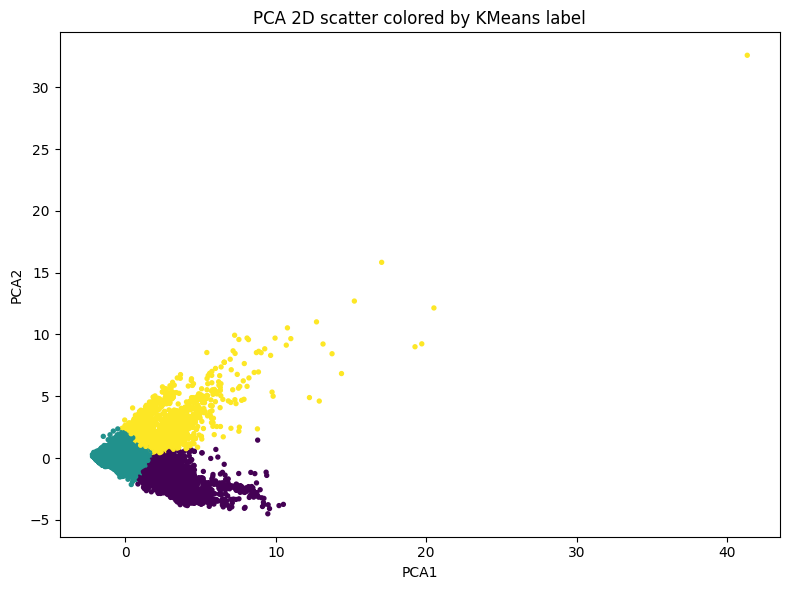

In [19]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
merged['pca1'] = X_pca[:,0]; merged['pca2'] = X_pca[:,1]
print('Explained variance ratio (2 comp):', pca.explained_variance_ratio_.sum())

# Simple scatter plot of PCA colored by KMeans labels
plt.figure(figsize=(8,6))
labels = merged['kmeans_label'].astype(int).values
plt.scatter(merged['pca1'], merged['pca2'], s=8, cmap='viridis', c=labels)
plt.title('PCA 2D scatter colored by KMeans label')
plt.xlabel('PCA1'); plt.ylabel('PCA2')
plt.tight_layout()
plt.show()

## 7. Cluster profiling
Summary statistics for each KMeans cluster (average pollutant values, top countries/cities).

In [20]:
# Cluster summaries
cluster_summary = merged.groupby('kmeans_label')[[c for c in features]].agg(['count','mean','std']).transpose()
cluster_summary

kmeans_label                     0             1            2
AQI_Score       count  2410.000000  19651.000000  1775.000000
                mean     89.720498     26.753417    57.804056
                std      29.654804     10.864288    22.376585
CO AQI Value    count  2410.000000  19651.000000  1775.000000
                mean      2.246888      0.991502     4.370141
                std       1.367672      0.611742     5.148188
Ozone AQI Value count  2410.000000  19651.000000  1775.000000
                mean     90.966805     30.088800    16.044507
                std      52.265040     13.012951    14.406631
NO2 AQI Value   count  2410.000000  19651.000000  1775.000000
                mean      1.886722      1.946059    17.046197
                std       2.430783      2.561317     8.941442
PM2.5 AQI Value count  2410.000000  19651.000000  1775.000000
                mean    176.751037     50.370363   125.779718
                std      75.730165     25.758074    52.843203

In [21]:
# Top cities per cluster
top_per_cluster = merged.groupby('kmeans_label').apply(lambda d: d.sort_values('AQI_Score', ascending=False).head(5)[['Country','City','AQI_Score']])
top_per_cluster

/tmp/ipython-input-2844568170.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_per_cluster = merged.groupby('kmeans_label').apply(lambda d: d.sort_values('AQI_Score', ascending=False).head(5)[['Country','City','AQI_Score']])


Country           City  AQI_Score
kmeans_label                                                                  
0            6888                              India          Aonla      223.0
             13823                             India       Puranpur      218.6
             23187                             India         Bilari      216.0
             22425                             India       Barkhera      215.8
             615                               India        Gunnaur      215.0
1            814                                 NaN      Kingstown       70.2
             3971                              Niger          Arlit       69.8
             8252                              Aruba     Oranjestad       69.8
             10125                             India         Bantva       69.8
             14938                           Senegal          Dahra       69.6
2            5233           United States of America        Durango      237.2
             18461                      South Africa       Boksburg      216.0
             22614                Russian Federation          Tynda      199.2
             13615  Democratic Republic of the Congo  Kasongo Lunda      197.8
             1417                  Republic of Korea          Seoul      189.6